The purpose here is to plot the seeing in the dc1 region

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import os

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.stackers as mafStackers
import time
import healpy as hp
import numpy as np

first lets see the saved plots (skymaps)

In [3]:
db_path = '/global/cscratch1/sd/awan/dbs_old_unzipped/minion_1016_sqlite_new_dithers.db'
outdir = '/global/cscratch1/sd/awan/seeing_minion_2016_new_dithers'
nside_data = 256

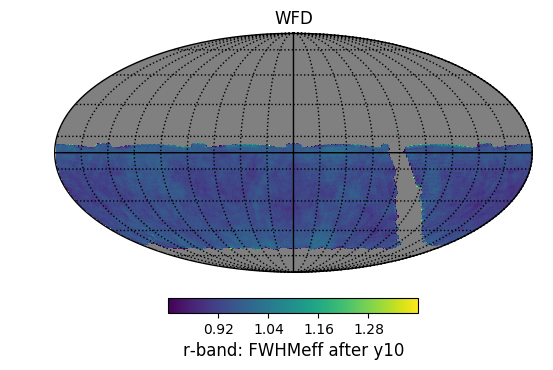

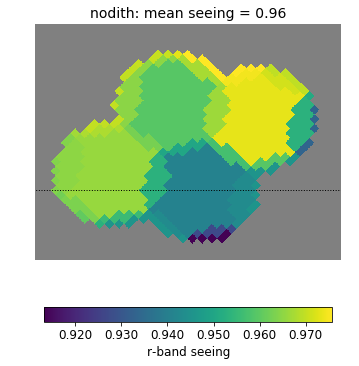

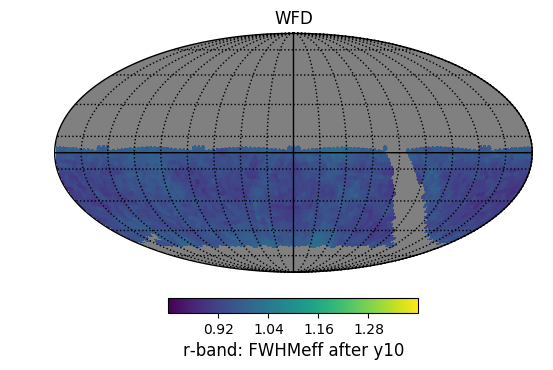

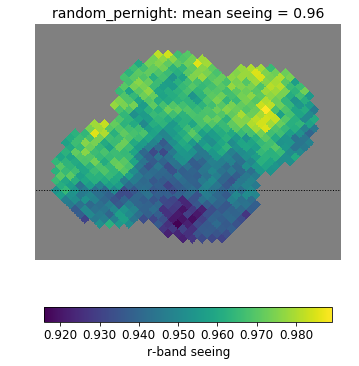

In [4]:
pngs = [f for f in os.listdir(outdir) if f.endswith('png')]
for png in pngs:
    display(Image(filename='%s/%s'%(outdir, png)) )

now lets zoom into the dc1 region. in order to do that, we first need to read in the pickle that contains the hpixel numbers for each visit considered in dc1.

In [5]:
import pickle
import itertools

In [6]:
reg = '/global/homes/a/awan/LSST/lsstRepos/DC1-Regions/chipsPerVisitData/'
reg += '2017-04-06_chipPerVisitData_newAfterburnerOutput_fID1447_RandomDitherFieldPerVisit_randomRotDithered_nonDiscRegion_nside1024_192103NonWFChipsToSimulate.pickle'
with open(reg, 'rb') as handle:
    dc1_data = pickle.load(handle, encoding='latin1')

In [7]:
# lets flatten the array
dc1_pix = np.unique(list(itertools.chain(*dc1_data['pixNum'])))

# downgrade
arr = np.zeros(hp.nside2npix(1024))
arr[dc1_pix] = 1000
dc1_pix = hp.ud_grade(map_in=arr, nside_out=nside_data)
#dc1_pix = dc1_pix.astype(int)

now we can plot cartview plots for the seeing zoomed in on the dc1 region

In [8]:
import numpy.ma as ma

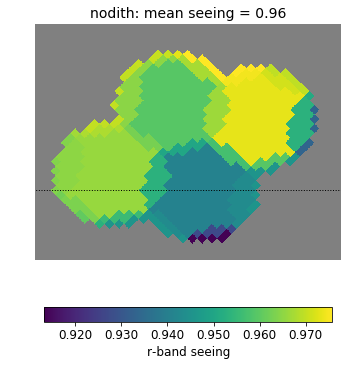

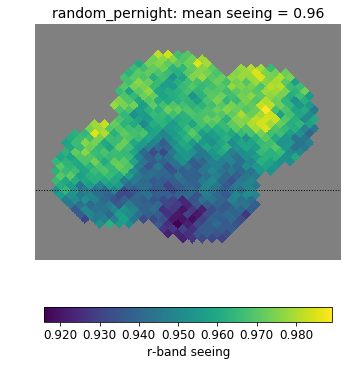

In [9]:
for dith in ['nodith', 'random_pernight']:
    dat = np.load('%s/seeing_r_%s.npz'%(outdir, dith))
    seeing_data = ma.masked_array(dat['metricValues'], mask=dat['mask'])
    seeing_data.fill_value = dat['fill']
    
    seeing_data.mask[:] = True
    seeing_data.mask[dc1_pix>0] = False

    plt.clf()
    hp.cartview(seeing_data, 
                flip='astro', rot=(0,0,0) ,
                lonra= [88, 99], latra=[-32.5, -24],
                #min=0.8, max=1.4,
                title= '', cbar=False)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.title('%s: mean seeing = %.2f'%(dith, np.mean(seeing_data.data[dc1_pix>0])), size=14)
    ax = plt.gca()
    im = ax.get_images()[0]
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    cbaxes = fig.add_axes([0.1, 0.0, 0.8, 0.04]) # [left, bottom, width, height]
    cb = plt.colorbar(im,  orientation='horizontal',
                      format= '%.3f', cax = cbaxes) 
    cb.set_label('r-band seeing', fontsize=12)
    cb.ax.tick_params(labelsize=12)
    filename = 'seeing_dc1_r_%s.png'%dith
    plt.savefig('%s/%s'%(outdir, filename), format='png',  bbox_inches='tight')
    plt.show()